# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
import math
import os
import cv2

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')
image = mat['I_noisefree']
I1 = mat['I_noisy1']
I2 = mat['I_noisy2']
I3 = mat['I_noisy3']
I4 = mat['I_noisy4']

images = [image, I1, I2, I3, I4]

def img_show(image):
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()

def img_compare(original, resized):
    fig1, (o, r) = plt.subplots(1, 2, figsize=(10, 5))
    o.imshow(original, cmap="gray")
    o.set(xticks=[], yticks=[])
    o.set_title('Obraz oryginalny')

    r.imshow(resized, cmap="gray")
    r.set(xticks=[], yticks=[])
    r.set_title('Obraz przekształcony')

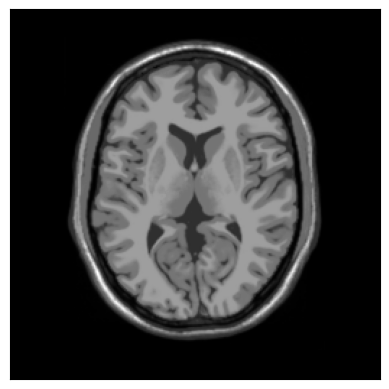

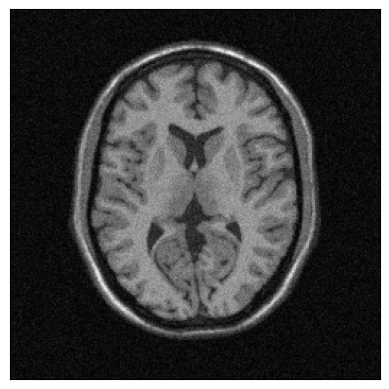

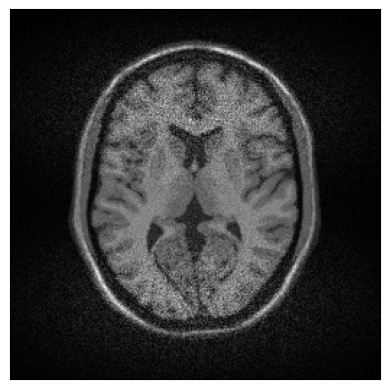

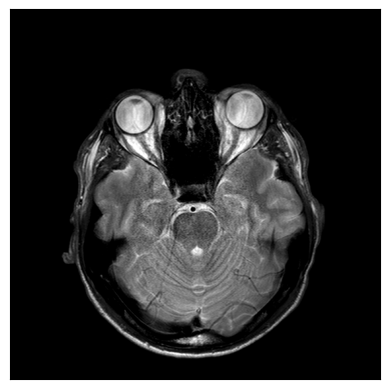

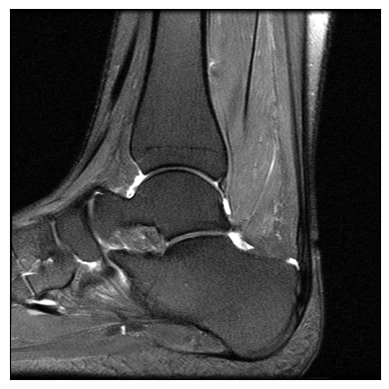

In [2]:
for image in images:
    img_show(image)

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [3]:
def pixel_conv(window, variancy):
    X, Y = window.shape
    pixel = 0
    norm = 0
    x = [X//2, Y//2]
    for i in range(X):
        for j in range(Y):
            AB = [i, j]
            y = np.sqrt(((x[0]-AB[0])**2)+((x[1]-AB[1])**2))
            gaus = np.exp(-(y**2)/(2*(variancy**2)))
            pixel = pixel + gaus*window[i, j]
            norm += gaus
    pixel = pixel/norm
    return pixel


def conv(image, window, variancy):
    IConv = image.copy()
    (X, Y) = IConv.shape
    polowa = window//2
    for i in range(0+window//2, X-window//2):
        for j in range(0+window//2, Y-window//2):
            okno = IConv[i-polowa:i+polowa+1, j-polowa:j+polowa+1]
            new_pixel = pixel_conv(okno, variancy)
            IConv[i, j] = new_pixel
    return IConv

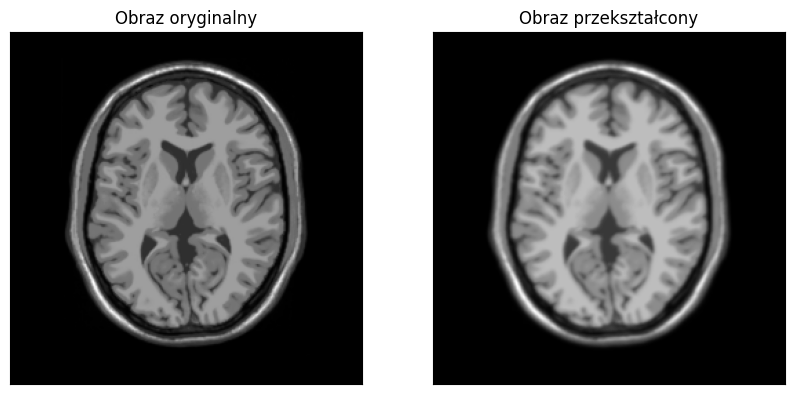

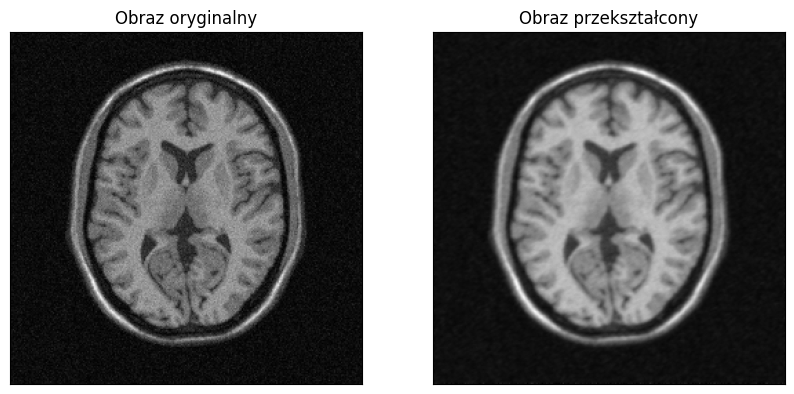

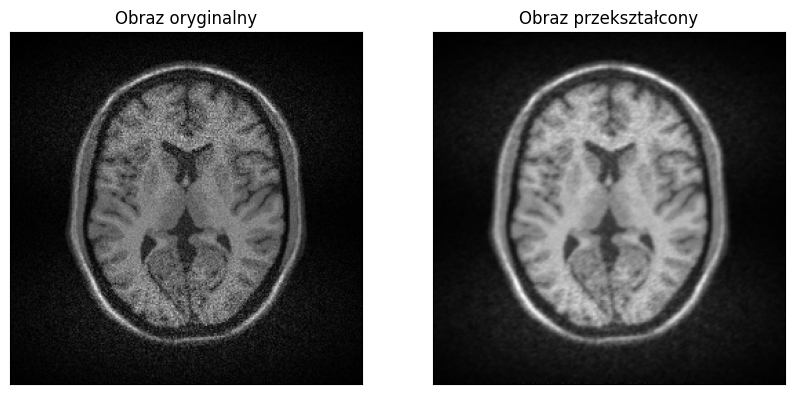

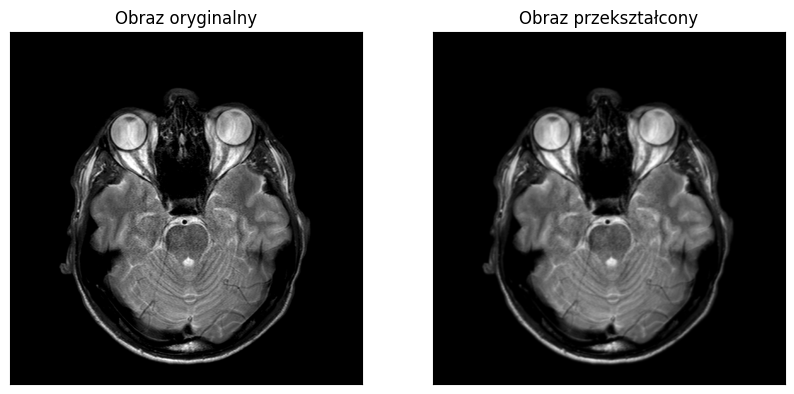

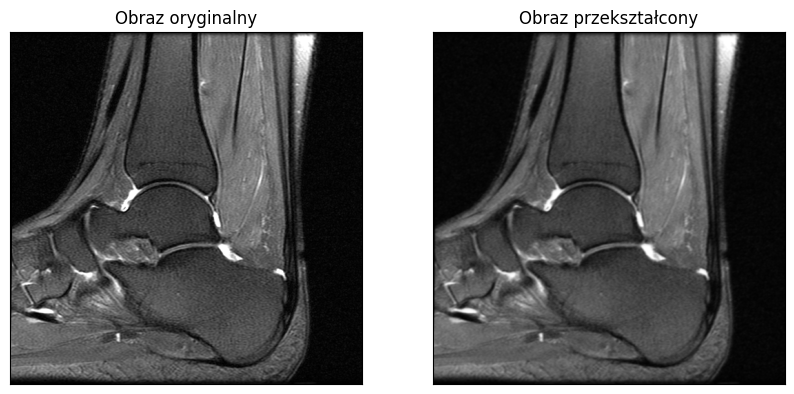

In [4]:
for image in images:
    img_compare(image, conv(image, 3, 20))

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [5]:
def pixel_bil(window, sigma_S, sigma_R):
    A, B = window.shape
    pixel = 0
    norm = 0
    x1, x2  = A // 2, B // 2
    for i in range(A):
        for j in range(B):
            px, py = i, j
            dist_L2 = np.sqrt((x1 - px)**2 + (x2 - py)**2)
            gaus_L2 = np.exp(-dist_L2**2 / (2 * sigma_S**2))
            y = np.abs(window[px, py] - window[x1, x2])
            gausY = np.exp(-y**2 / (2 * sigma_R**2))
            pixel += gaus_L2 * gausY * window[i, j]
            norm += gaus_L2 * gausY
    pixel /= norm
    return pixel

def billateral(image, size, sigma_S, sigma_R):
    IBilateral = image.copy()
    X, Y = IBilateral.shape
    h = size // 2
    for i in range(h, X - h):
        for j in range(h, Y - h):
            w = IBilateral[i - h:i + h + 1, j - h: j + h +1]
            pix = pixel_bil(w, sigma_S, sigma_R)
            IBilateral[i, j] = pix
    return IBilateral


/var/folders/_1/w52qf3p97d761kcqp1lbqq480000gn/T/ipykernel_75666/3341439226.py:11: RuntimeWarning: overflow encountered in scalar subtract
  y = np.abs(window[px, py] - window[x1, x2])


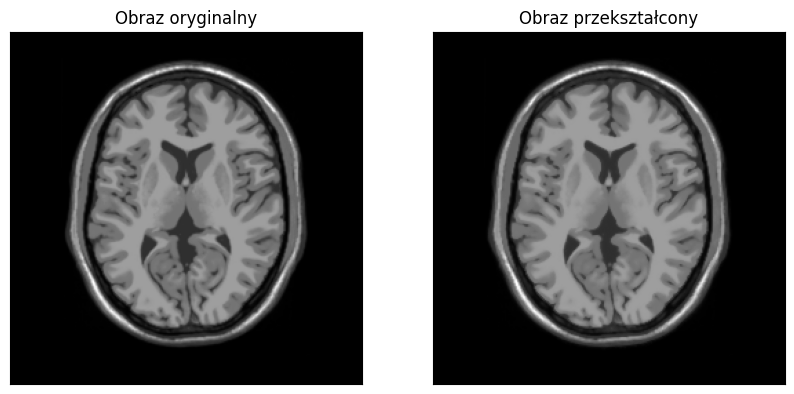

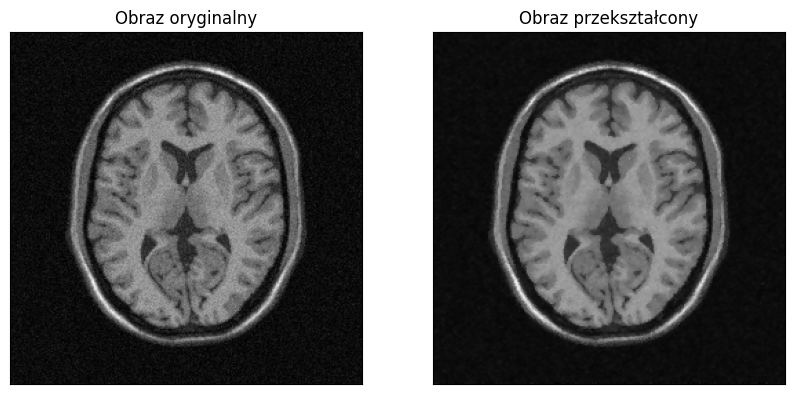

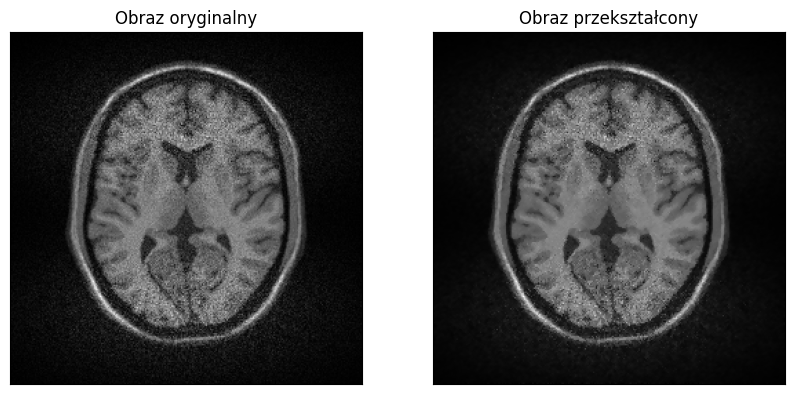

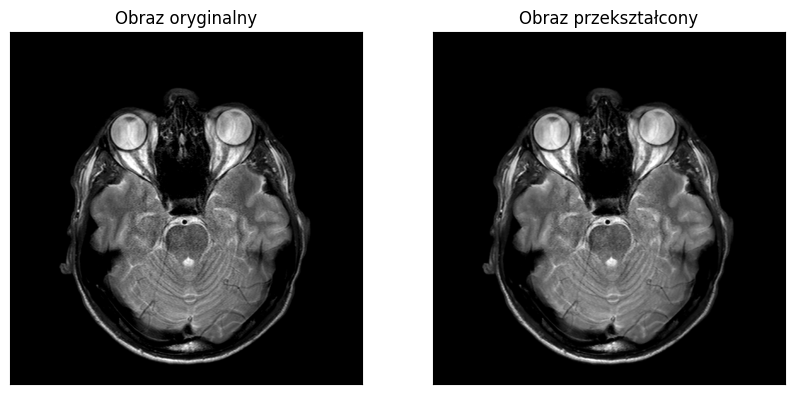

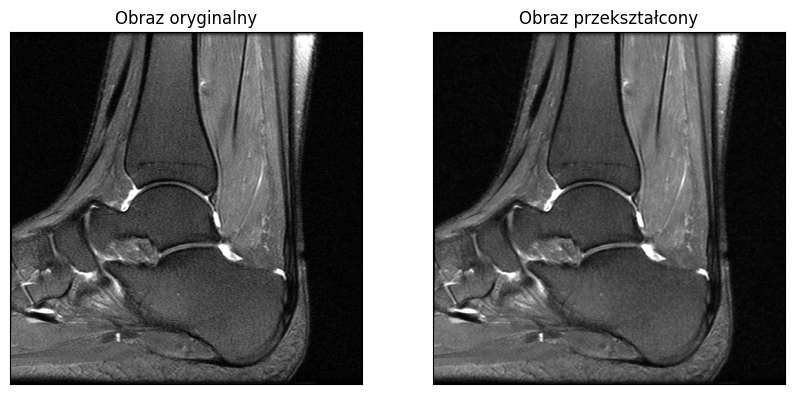

In [6]:
for image in images:
    img_compare(image, billateral(image, 3, 15, 15))